In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
exp_dir = '/discover/nobackup/agstubbl/ISSM/projs/IRF-ISSM/'
filename = exp_dir+'mesh.nc'
f = netCDF4.Dataset(filename, 'r')

In [3]:
# for key in f.variables.keys():
#     print(f[key])

In [4]:
# mesh nodes
longitudes = f['nodeCoords_lon'][:].data.astype('float')
latitudes = f['nodeCoords_lat'][:].data.astype('float')

# element Ids (for check)
elementIds = f['elementIds'][:].data.astype('int')

# mesh elements
elementConn_n1 = f['elementConn_n1'][:].data.astype('int')
elementConn_n2 = f['elementConn_n2'][:].data.astype('int')
elementConn_n3 = f['elementConn_n3'][:].data.astype('int')

# ice elevation
ice_elevation = f['ice_elevation'][:].data.astype('float')

triangles = np.zeros((elementConn_n1.size,3))
triangles[:,0] = elementConn_n1-1
triangles[:,1] = elementConn_n2-1
triangles[:,2] = elementConn_n3-1

triang = Triangulation(longitudes,latitudes,triangles)

/usr/local/other/anaconda/GEOSpyD/24.3.0-0/2024-08-29/envs/py3.12/envs/viz/lib/python3.11/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)


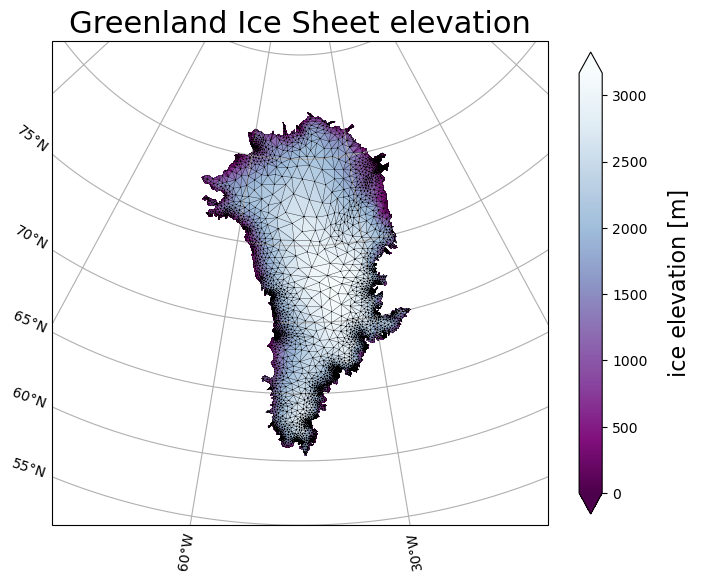

In [5]:
fig = plt.figure(figsize=(8, 8))

proj = ccrs.LambertConformal(central_longitude=-45, central_latitude=70)

ax = plt.axes(projection=proj)

# Set extent around Greenland: [west_lon, east_lon, south_lat, north_lat]
ax.set_extent([-80, -10, 55, 85], crs=ccrs.PlateCarree())


# Add gridlines
gl = ax.gridlines(draw_labels=True, 
                  dms=True, 
                  x_inline=False, 
                  y_inline=False)
gl.top_labels = False
gl.right_labels = False
ax.triplot(triang,color='k',linewidth=0.25,transform=ccrs.PlateCarree(),zorder=100)
p1 = ax.tripcolor(triang,facecolors=ice_elevation,cmap='BuPu_r',transform=ccrs.PlateCarree())
cbar = plt.colorbar(p1,extend='both',shrink=0.75)
cbar.set_label(r'ice elevation [m]',fontsize=16,labelpad=15)
# Show the plot
plt.title("Greenland Ice Sheet elevation",fontsize=22)
plt.show()

In [9]:
# plot some elements to make sure that the ordering
# of the nodes is correct (should be counter-clockwise red-green-blue)
# plt.figure(figsize=(4,4))
# plt.title('R-G-B counterclockwise',fontsize=12)
# for j in [500,507,497]:
#     # for plotting, have to subtract index by 1 to convert
#     # to python zero-based indexing
#     x_n1 = longitudes[elementConn_n1[elementIds[j]]-1]
#     y_n1 = latitudes[elementConn_n1[elementIds[j]]-1]
    
#     x_n2 = longitudes[elementConn_n2[elementIds[j]]-1]
#     y_n2 = latitudes[elementConn_n2[elementIds[j]]-1]
    
#     x_n3 = longitudes[elementConn_n3[elementIds[j]]-1]
#     y_n3 = latitudes[elementConn_n3[elementIds[j]]-1]

#     # centroid of triangle
#     x_c = (x_n1+x_n2+x_n3)/3.0
#     y_c = (y_n1+y_n2+y_n3)/3.0

#     plt.plot([x_n1,x_n2,x_n3,x_n1], [y_n1,y_n2,y_n3,y_n1], 'k--',linewidth=2)
#     plt.plot([x_n1], [y_n1], 'ro',markersize=10,markeredgecolor='k')
#     plt.plot([x_n2], [y_n2], 'go',markersize=10,markeredgecolor='k')
#     plt.plot([x_n3], [y_n3], 'bo',markersize=10,markeredgecolor='k')
#     plt.annotate(str(j),xy=(x_c,y_c),fontsize=12,color='deeppink',fontweight='bold',horizontalalignment='center')
#     plt.xlabel(r'$x$',fontsize=16)
#     plt.ylabel(r'$y$',fontsize=16)
# plt.gca().set_aspect('equal')
# plt.show()
# plt.close()